In [1]:
# import necessary modules
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf


In [2]:
file_name = '-train-rgs-galah'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-GALAH/'
file_path = '../data/master-APOGEE-giants-GALAH.fits'
spectra_data, label_data = ld.load_data_galah(spectra_dir_path, file_path, file_name)

../spec/spectra-reference-stars-APOGEE-giants-GALAH/spectra_data-train-rgs-galah.dat
File already exists. Loading spectra data


22it [00:01, 12.09it/s]


Loaded data successfully


In [3]:
n = 4000

train_ID = label_data['ids'][:n]
train_flux = spectra_data['fluxes'][:n]
train_flux_err = spectra_data['fluxes_err'][:n]
train_flux_ivar = spectra_data['fluxes_ivars'][:n]
train_label = label_data['labels'][:n]
train_label_err = label_data['labels_err'][:n]
train_label_ivar = label_data['labels_ivars'][:n]

test_ID = label_data['ids'][n:]
test_flux = spectra_data['fluxes'][n:]
test_flux_err = spectra_data['fluxes_err'][n:]
test_flux_ivar = spectra_data['fluxes_ivars'][n:]
test_label = label_data['labels'][n:]
test_label_err = label_data['labels_err'][n:]
test_label_ivar = label_data['labels_ivars'][n:]

In [4]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-giantsgalah'
alphas = np.load(savepath+'alphas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
betas = np.load(savepath+'betas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
zetas = np.load(savepath+'zetas_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
ln_noise_fluxes_updated = jnp.log(np.load(savepath+'noise_fluxes_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True))


# compute the new zetas

In [27]:
# first using the fluxes
P = 49
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)

In [28]:
res_zetas_fromfluxes = opt_sc.get_zetas_test_using_fluxes(test_flux, test_flux_ivar, betas, zetas_init_test, ln_noise_fluxes_updated)
zetas_test_fromfluxes = res_zetas_fromfluxes.params['zetas']

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 1615611940487.9392, Curvature error: 1.734880235891811e+18


KeyboardInterrupt: 

In [7]:
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T

In [8]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-giantsgalah'
np.save(savepath+'zetas_test_fromflux_giants-withscatters'+str(name), zetas_test_fromfluxes)
np.save(savepath+'labels_test_fromflux_giants-withscatters'+str(name), labels_test_fromflux)
np.save(savepath+'spectra_test_fromflux_giants-withscatters'+str(name), spectra_test_fromflux)


In [5]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-giantsgalah'
zetas_test_fromfluxes = np.load(savepath+'zetas_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromflux = np.load(savepath+'labels_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromflux = np.load(savepath+'spectra_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)

In [6]:
test_snr = label_data['snr'][4000:]

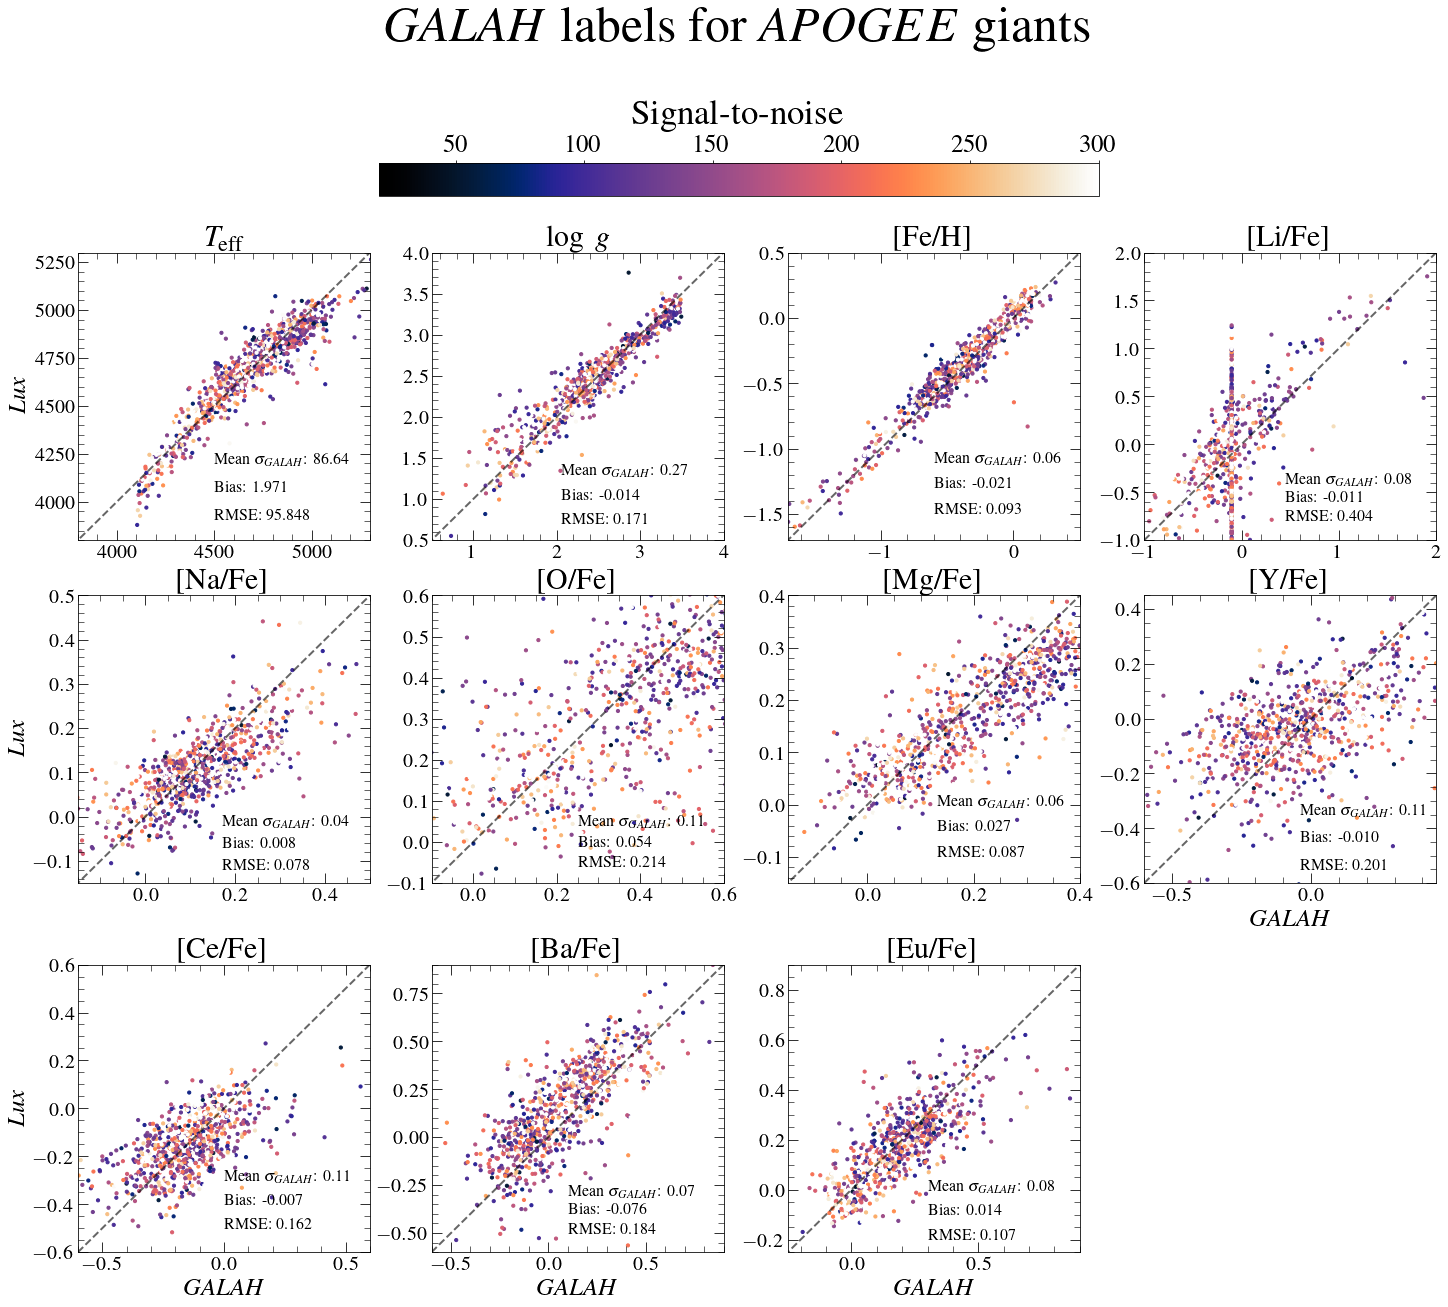

In [7]:
n = 10000
fig = plt.figure(figsize=(20,15), constrained_layout=True)
fig.suptitle('$GALAH$ labels for $APOGEE$ giants',fontsize=50,x=0.51,y=1.2)

plt.subplot(3,4,1)
plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.plot([3500,5500], [3500,5500], color='k',alpha=0.6, lw=2, ls='dashed')
color = plt.scatter(test_label[:n,0], labels_test_fromflux[:,0], c=test_snr, s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.text(4500,3900, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
plt.text(4500,4050, 'Bias: '+str("{:.3f}".format(jnp.median(test_label[:n,0]-labels_test_fromflux[:,0]))), fontsize=16)
plt.text(4500,4200, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(3800,5300)
plt.ylim(3800,5300)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,2)
plt.title('$\log~g$', fontsize=30)
plt.plot([0,4],[0,4], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(2.05,0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
plt.text(2.05,1.0, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromflux[:,1]))), fontsize=16)
plt.text(2.05,1.3, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.scatter(test_label[:n,1], labels_test_fromflux[:,1], c=test_snr, s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(0.5,4)
plt.ylim(0.5,4)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,3)
plt.title('[Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.6,-1.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
plt.text(-0.6,-1.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
plt.text(-0.6,-1.1, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.scatter(test_label[:n,2], labels_test_fromflux[:,2], c=test_snr, s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-1.7,0.5)
plt.ylim(-1.7,0.5)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,4)
plt.title('[Li/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,3])<3)&(np.abs(test_label[:,3])<3)&((test_label[:,3]<-2)|(test_label[:,3]>-2))
plt.plot([-1,2], [-1,2], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.45,-0.8, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,3][mask]-labels_test_fromflux[:,3][mask])**2))))), fontsize=16)
plt.text(0.45,-0.6, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,3][mask]-labels_test_fromflux[:,3][mask]))), fontsize=16)
plt.text(0.45,-0.4, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,3][mask&(np.abs(test_label_err[:n,3])<3)]))), fontsize=16)
plt.scatter(test_label[:n,3][mask], labels_test_fromflux[:,3][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-1,2)
plt.ylim(-1,2)
# plt.xlabel(r'ASPCAP', fontsize=20)
# plt.ylabel(r'The Paton', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,5)
plt.title('[Na/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,4])<1)&(np.abs(test_label[:,4])<1)&(np.abs(test_label_err[:n,4])<1)
plt.plot([-0.5,1.], [-0.5,1.], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.17,-0.12, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,4][mask]-labels_test_fromflux[:,4][mask])**2))))), fontsize=16)
plt.text(0.17,-0.07, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,4][mask]-labels_test_fromflux[:,4][mask]))), fontsize=16)
plt.text(0.17,-0.02, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,4][mask]))), fontsize=16)
plt.scatter(test_label[:n,4][mask], labels_test_fromflux[:,4][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.15,0.5)
plt.ylim(-0.15,0.5)
plt.ylabel(r'$Lux$', fontsize=25)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,6)
plt.title('[O/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,5])<1)&(np.abs(test_label_err[:n,5])<1)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.25,-0.06, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,5][mask]-labels_test_fromflux[:,5][mask])**2))))), fontsize=16)
plt.text(0.25,-0.01, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,5][mask]-labels_test_fromflux[:,5][mask]))), fontsize=16)
plt.text(0.25,0.04, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,5][mask]))), fontsize=16)
plt.scatter(test_label[:n,5][mask], labels_test_fromflux[:,5][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.1,0.6)
plt.ylim(-0.1,0.6)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,7)
plt.title('[Mg/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.13,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromflux[:,6])**2))))), fontsize=16)
plt.text(0.13,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,6]-labels_test_fromflux[:,6]))), fontsize=16)
plt.text(0.13,0., 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)
plt.scatter(test_label[:n,6], labels_test_fromflux[:,6], c=test_snr, s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.15,0.4)
plt.ylim(-0.15,0.4)
# plt.ylabel(r'The Paton', fontsize=20)
# plt.xlabel(r'ASPCAP', fontsize=20)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,8)
plt.title('[Y/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,7])<1) &(np.abs(test_label[:,7])<1) & ((test_label[:,7]>0.144312554)|(test_label[:,7]<0.144312552))\
    &(np.abs(test_label_err[:n,7])<1)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(-0.04,-0.55, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,7][mask]-labels_test_fromflux[:,7][mask])**2))))), fontsize=16)
plt.text(-0.04,-0.45, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,7][mask]-labels_test_fromflux[:,7][mask]))), fontsize=16)
plt.text(-0.04,-0.35, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,7][mask]))), fontsize=16)
plt.scatter(test_label[:n,7][mask], labels_test_fromflux[:,7][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.6,0.45)
plt.ylim(-0.6,0.45)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'$GALAH$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,9)
plt.title('[Ce/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,8])<1)&(np.abs(test_label_err[:n,8])<1)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.,-0.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,8][mask]-labels_test_fromflux[:,8][mask])**2))))), fontsize=16)
plt.text(0.,-0.4, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,8][mask]-labels_test_fromflux[:,8][mask]))), fontsize=16)
plt.text(0.,-0.3, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,8][mask]))), fontsize=16)
plt.scatter(test_label[:n,8][mask], labels_test_fromflux[:,8][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'$GALAH$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,10)
plt.title('[Ba/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,9])<1)&(np.abs(test_label_err[:n,9])<1)
plt.plot([-0.6,0.9], [-0.6,0.9], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.1,-0.5, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,9][mask]-labels_test_fromflux[:,9][mask])**2))))), fontsize=16)
plt.text(0.1,-0.4, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,9][mask]-labels_test_fromflux[:,9][mask]))), fontsize=16)
plt.text(0.1,-0.3, 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,9][mask]))), fontsize=16)
plt.scatter(test_label[:n,9][mask], labels_test_fromflux[:,9][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.6,0.9)
plt.ylim(-0.6,0.9)
# plt.ylabel(r'The Paton', fontsize=25)
plt.xlabel(r'$GALAH$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(3,4,11)
plt.title('[Eu/Fe]', fontsize=30)
mask = (np.abs(labels_test_fromflux[:,10])<1) &(np.abs(test_label[:,10])<1) & ((test_label[:,10]>0.144312554)|(test_label[:,10]<0.144312552))\
&(np.abs(test_label_err[:n,10])<1)
plt.plot([-0.6,0.9], [-0.6,0.9], color='k',alpha=0.6, lw=2, ls='dashed')
plt.text(0.3,-0.2, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label[mask])*(jnp.nansum((test_label[:n,10][mask]-labels_test_fromflux[:,10][mask])**2))))), fontsize=16)
plt.text(0.3,-0.1, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,10][mask]-labels_test_fromflux[:,10][mask]))), fontsize=16)
plt.text(0.3,0., 'Mean $\sigma_{GALAH}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,10][mask]))), fontsize=16)
plt.scatter(test_label[:n,10][mask], labels_test_fromflux[:,10][mask], c=test_snr[mask], s=10, vmin=20, vmax=300, cmap=cm.torch)
plt.xlim(-0.25,0.9)
plt.ylim(-0.25,0.9)
# plt.ylabel(r'The Paton', fontsize=20)
plt.xlabel(r'$GALAH$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.26, 1.025, 0.5,0.03])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'Signal-to-noise',fontsize=35,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/CV-test-galahstars-lux.pdf',dpi=200, bbox_inches = 'tight')

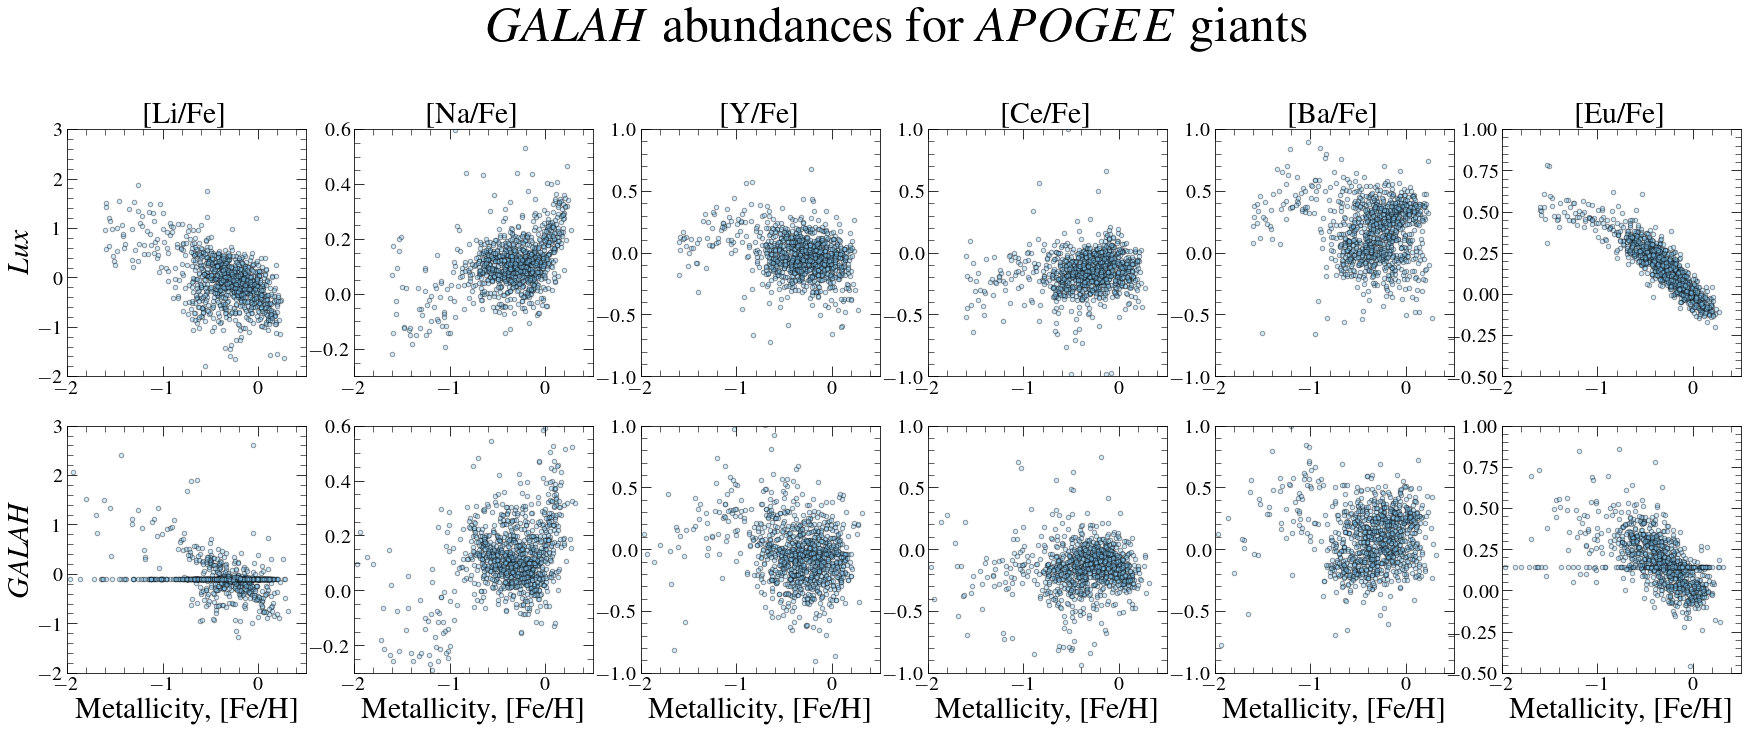

In [8]:
fig = plt.figure(figsize=(30, 10), facecolor='white')
fig.suptitle('$GALAH$ abundances for $APOGEE$ giants',fontsize=50,x=0.51,y=1.05)

plt.subplot(2,6,1)
plt.title('[Li/Fe]', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,3], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.ylabel('$Lux$', fontsize=30)
plt.xlim(-2,0.5)
plt.ylim(-2,3)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,2)
plt.title('[Na/Fe]', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,4], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-0.3,0.6)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,3)
plt.title('[Y/Fe]', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,7], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,4)
plt.title('[Ce/Fe]', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,8], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,5)
plt.title('[Ba/Fe]', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,9], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-1,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,6)
plt.title('[Eu/Fe]', fontsize=30)
plt.scatter(labels_test_fromflux[:,2], labels_test_fromflux[:,10], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-0.5,1)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()


plt.subplot(2,6,7)
# plt.title('[Li/Fe]', fontsize=25)
plt.ylabel('$GALAH$', fontsize=30)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.xlim(-2,0.5)
plt.ylim(-2,3)
plt.scatter(test_label[:,2], test_label[:,3], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,8)
# plt.title('[Na/Fe]', fontsize=25)
plt.scatter(test_label[:,2], test_label[:,4], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-0.3,0.6)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,9)
# plt.title('[Y/Fe]', fontsize=25)
plt.scatter(test_label[:,2], test_label[:,7], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-1,1)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,10)
# plt.title('[Ce/Fe]', fontsize=25)
plt.scatter(test_label[:,2], test_label[:,8], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-1,1)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,11)
# plt.title('[Ba/Fe]', fontsize=25)
plt.scatter(test_label[:,2], test_label[:,9], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-1,1)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,6,12)
# plt.title('[Eu/Fe]', fontsize=25)
plt.scatter(test_label[:,2], test_label[:,10], s=20, c='lightskyblue', alpha=0.4, edgecolors='k')
plt.xlim(-2,0.5)
plt.ylim(-0.5,1)
plt.xlabel('Metallicity, [Fe/H]', fontsize=30)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/abundances-galahstars-Lux.pdf',dpi=200, bbox_inches = 'tight')

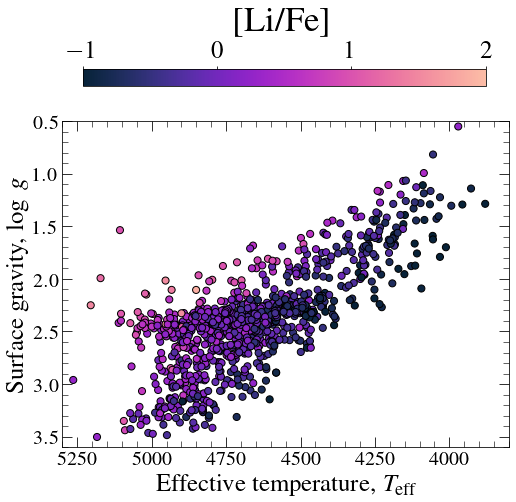

In [117]:
fig = plt.figure(figsize=(8,6), facecolor='white')

color = plt.scatter(labels_test_fromflux[:,0], labels_test_fromflux[:,1], c=labels_test_fromflux[:,3], s=50, cmap=cm.bubblegum, edgecolors='k', vmin=-1, vmax=2)
plt.xlim(5300,3800)
plt.ylim(3.6, 0.5)
# plt.colorbar(label='[Li/Fe]')
plt.xlabel('Effective temperature, $T_{\mathrm{eff}}$', fontsize=25)
plt.ylabel('Surface gravity, $\log~g$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

cbar_ax = fig.add_axes([0.16, 0.96, 0.7,0.04])
cb = plt.colorbar(cax = cbar_ax,orientation='horizontal')
cb.set_label(label=r'[Li/Fe]',fontsize=35,labelpad=10)
cb.ax.tick_params(labelsize=25)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')